<a href="https://colab.research.google.com/github/leonardoLavagna/PyTorch-Notebooks/blob/main/Notebook_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Notebook 5
## Multiclass Classification
In this notebook we will carry out a multiclass classification model. Recall a binary classification problem deals with classifying something as one of two options (e.g. a photo as a cat photo or a dog photo) where as a multi-class classification problem deals with classifying something from a list of more than two options (e.g. classifying a photo as a cat a dog or a bee). 

To begin a multi-class classification problem, let's create some multi-class data. To do so, we can leverage Scikit-Learn's `make_blobs()` method. Then we will follow the usal standar pipelane to make inference on this dataset.

tensor([[ 7.3478, -3.5524],
        [-1.2500,  4.6749],
        [-0.7613,  5.1414],
        [-2.9264,  6.6315],
        [ 3.5321, -4.9909]]) tensor([2, 3, 1, 3, 2])


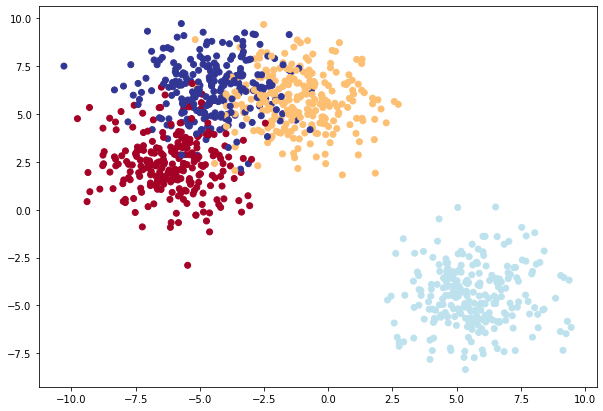

In [ ]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 1234

# Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,n_features=NUM_FEATURES, 
                            centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,test_size=0.2,random_state=RANDOM_SEED)

# Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [ ]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        Initializes all required hyperparameters for a multi-class classification model.

        ARGS:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model (blobs)
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features)
            )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model = BlobModel(input_features=NUM_FEATURES,output_features=NUM_CLASSES,hidden_units=8).to(device)

In [ ]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)

In [ ]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

In [ ]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### TRAINING
    model.train()

    # Forward pass
    # model outputs raw logits 
    y_logits = model(X_blob_train) 
    # logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) 
    # Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,y_pred=y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backwards
    loss.backward()

    # Optimizer step
    optimizer.step()

    ### TESTING
    model.eval()
    with torch.inference_mode():
      # Forward pass
      test_logits = model(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 20 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}, Acc: {acc}% | Test Loss: {test_loss}, Test Acc: {test_acc}%")

Epoch: 0 | Loss: 1.8979716300964355, Acc: 1.25% | Test Loss: 1.691368579864502, Test Acc: 14.000000000000002%
Epoch: 20 | Loss: 0.7192849516868591, Acc: 70.875% | Test Loss: 0.743537425994873, Test Acc: 66.0%
Epoch: 40 | Loss: 0.5690180063247681, Acc: 83.875% | Test Loss: 0.5833911299705505, Test Acc: 82.5%
Epoch: 60 | Loss: 0.4906797707080841, Acc: 86.25% | Test Loss: 0.4962436556816101, Test Acc: 87.5%
Epoch: 80 | Loss: 0.4418092668056488, Acc: 86.875% | Test Loss: 0.4412475824356079, Test Acc: 88.0%


In [ ]:
# Make predictions
model.eval()
with torch.inference_mode():
    y_logits = model(X_blob_test)

In [ ]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([2, 0, 1, 2, 0, 1, 0, 2, 0, 0])
Labels: tensor([2, 0, 1, 2, 0, 1, 0, 2, 0, 0])
Test accuracy: 88.0%


In [ ]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/leonardoLavagna/PyTorch-Notebooks/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


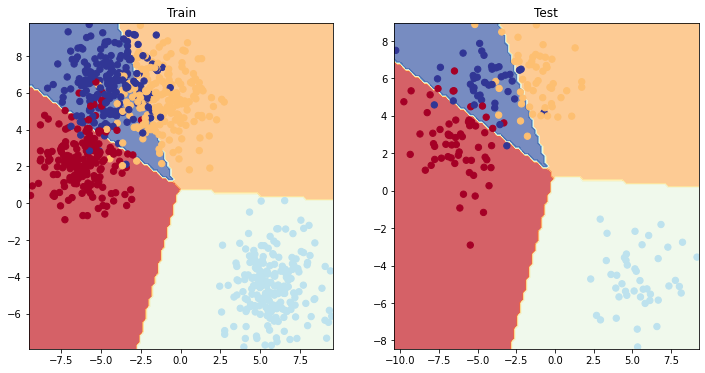

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_blob_test, y_blob_test)

## Exercises 

1.   Create a multi-class dataset using the spirals data creation function from (see below for the code).
2.   Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
3.   Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working)
4.   Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
5.   Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

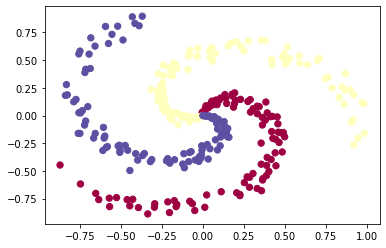

In [ ]:
# Code for creating a spiral dataset 
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()